In [27]:
#|hide
#|default_exp experiments.graph_volume_normalization
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *

# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm, trange

## project specifics
import diffusion_curvature
import pygsp
import jax
import jax.numpy as jnp


from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *
from diffusion_curvature.comparison_space import *

# Utility functions for literate programming
def get_var_name(instance):
    return [name for name, obj in globals().items() if obj is instance][0]

%load_ext autoreload
%autoreload 2
jax.devices()

[autoreload of diffusion_curvature.flattening.mioflow failed: Traceback (most recent call last):
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_gener

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[cuda(id=0), cuda(id=1)]

# 2c5 Graph Volume Normalization
> Resilience to sampling/density by normalizing the laziness by the volume.

## Preamble
Unsigned diffusion laziness conflates the speed and spread of diffusion, but this involves two interrelated phenomena:
1. Volume expansion, which happens faster in spaces of negative curvature.
2. *Laziness*, which is related to volume expansion, but also involves more interconnectivity between points. 

Can we separate speed from spread by normalizing the laziness by the number of points diffused to? On the sphere, the same *area* should have lazier diffusions than on the saddle.

I’m unsure if the laziness phenomenon is strong enough by itself. Normalizing by e.g. the number of points with diffusion higher than $\epsilon$ might just destroy the effect.
- But there could be ways of intensifying it. Perhaps taking circular subsets of the data and repeatedly diffusing just within that confined space?
- The ‘volume curves’ could also be matched between datasets

## Research Question

In this notebook, we investigate enhancing the sampling resilience of diffusion curvature by normalizing by the graph volume, as a proxy for density. The experiment first to be done is this:

> Does the diffusion laziness, normalized by a proxy of graph volume (e.g counting the number of points), still reveal curvature?

This will be tested on the `SadSpheres` dataset at various dimensions, and with various normalization schemes. Perhaps dividing, perhaps directly comparing curvature curves, perhaps some yet to be discovered means.

## Hypothesis

> When normalized by graph volume, the curvature curves of positive and negative datasets will reveal robust differences. The *laziness* of diffusion, in short, can be separated from how quickly it spreads.

## Result Summary

Normalizing the laziness by the volume *robustly enhances* the separation of curvature in 2 manifolds. However, in 3 manifolds, it seldom does so. There are several possible explanations:

1. Diffusion in 3-manifolds quickly runs against the *boundaries* of the manifold, creating edge effects. This is evident in the charts of graph volume over time shown below. 
   1. Possibly if allowed to diffuse for longer periods before running against the edges, more laziness would be apparent. 
      1. Possibly really small kernels could accomplish this.

# Machinery

We need to implement two main chunks.

1. A computation of graph volume, accomplished by summing up the number of points at in which each row of $P^t$ exceeds an epsilon threshold. We'll do this with a fastai style mixin that calls `unsigned_curvature`, extracts the `Pt` variable, and does its will.
2. A means of normalizing the unsigned curvature (laziness) by the resulting volume. The simplest is division, but I want to try several out. To do so, we'll define a series of normalization functions that take a,b and return some ratio of them. We also want direct access to the graph volumes and unsigned curvatures, so each normalization function will itself be a patch.

In [30]:
#|export
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from fastcore.all import *
from diffusion_curvature.core import *
import jax.numpy as jnp

@patch 
def graph_volumes(self:DiffusionCurvature, epsilon_threshold = 1e-5):
    """
    returns the graph volumes across all idxs. Presumes that Pt is precomputed.
    """
    idxs_above_threshold = (self.Pt > epsilon_threshold).astype(int)
    graph_volumes = jnp.sum(idxs_above_threshold, axis=-1)
    return graph_volumes

@patch
def division_normalized_laziness(self:DiffusionCurvature, G, t, epsilon_threshold, return_all = "norm"):
    laziness = self.unsigned_curvature(G, t)
    volumes = self.graph_volumes(epsilon_threshold = epsilon_threshold)
    norm = laziness / volumes
    if return_all == "all": return norm, laziness, volumes
    elif return_all == "volume": return volumes
    else: return norm

In [31]:
@patch 
def d_laziness_d_volume(self:DiffusionCurvature, G, t, epsilon_threshold):
    laziness = self.unsigned_curvature(G, t)
    volumes = self.graph_volumes(epsilon_threshold = epsilon_threshold)
    laziness_differences = laziness - jnp.concat([np.zeros(1), laziness[:-1]])
    volume_differences = volumes - jnp.concat([np.zeros(1), volumes[:-1]])
    return laziness_differences / volume_differences

In [32]:
@patch 
def differential_volume_normalized_laziness(self:DiffusionCurvature, G, t, epsilon_threshold):
    laziness = self.unsigned_curvature(G, t)
    volumes = self.graph_volumes(epsilon_threshold = epsilon_threshold)
    lv = laziness / volumes
    laziness_differences = lv - jnp.concat([np.zeros(1), lv[:-1]])
    return laziness_differences 

Wasserstein to Uniform: the above approaches all normalize more or less directly by volume, but it's clear that the w1 spread of diffusion is not linear in volume. Here, we compute a new formulation of laziness: the EMD between $P^t[idx]$ and the uniform distribution *on the diffused values*.

In [87]:
import ot
from tqdm.auto import tqdm, trange
from fastcore.all import *
def emd_at_idx(i, Pt, D, idxs_above_threshold):
        above_thresh = jnp.nonzero(idxs_above_threshold[i])[0]
        subset_Pt_at_i = Pt[i][above_thresh]
        uniform_above_this_diffusion = jnp.ones(len(above_thresh)) / len(above_thresh) 
        subset_D = D[above_thresh][:,above_thresh]
        print("beginning 1 computation")
        # laziness[i] = ot.emd2(subset_Pt_at_i, uniform_above_this_diffusion, subset_D)
        laziness = ot.emd2(np.array(subset_Pt_at_i), np.array(uniform_above_this_diffusion), np.array(subset_D))
        print("finished one computation")
        return laziness
    
@patch 
def wasserstein_to_uniform(self:DiffusionCurvature, G, t, epsilon_threshold):
    _ = self.unsigned_curvature(G, t)
    idxs_above_threshold = (self.Pt > epsilon_threshold).astype(int)
    # create uniform distribution over idxs
    # uniform_on_diffused = idxs_above_threshold / jnp.sum(idxs_above_threshold, axis=-1)[:,None]
    # take W1 distance from # TODO: this is W2
    # only do so within the idxs above the threshold
    emd_fn = partial(emd_at_idx, Pt = self.Pt, D = self.D, idxs_above_threshold=idxs_above_threshold)
    laziness = parallel(emd_fn, list(range(len(self.Pt))), n_workers=15)
    return laziness 

Approximate Wasserstein to Uniform

In [88]:
from diffusion_curvature.diffusion_laziness import wasserstein_spread_of_diffusion
@patch 
def wasserstein_to_uniform_approx(self:DiffusionCurvature, G, t, epsilon_threshold):
    _ = self.unsigned_curvature(G, t)
    idxs_above_threshold = (self.Pt > epsilon_threshold).astype(int)
    # create uniform distribution over idxs
    uniform_on_diffused = idxs_above_threshold / jnp.sum(idxs_above_threshold, axis=-1)[:,None]
    d_dirac_to_uniform = wasserstein_spread_of_diffusion(D = self.D, Pt = uniform_on_diffused)
    d_dirac_to_diffusion = wasserstein_spread_of_diffusion(D = self.D, Pt = self.Pt)
    d_diffusion_to_uniform_approx = d_dirac_to_uniform - d_dirac_to_diffusion
    return d_diffusion_to_uniform_approx 

Approximation Wasserstein divided by uniform:

In [107]:
from diffusion_curvature.diffusion_laziness import wasserstein_spread_of_diffusion
@patch 
def divided_wasserstein_to_uniform_approx(self:DiffusionCurvature, G, t, epsilon_threshold):
    _ = self.unsigned_curvature(G, t)
    idxs_above_threshold = (self.Pt > epsilon_threshold).astype(int)
    # create uniform distribution over idxs
    uniform_on_diffused = idxs_above_threshold / jnp.sum(idxs_above_threshold, axis=-1)[:,None]
    d_dirac_to_uniform = wasserstein_spread_of_diffusion(D = self.D, Pt = uniform_on_diffused)
    d_dirac_to_diffusion = wasserstein_spread_of_diffusion(D = self.D, Pt = self.Pt)
    d_diffusion_to_uniform_approx = d_dirac_to_diffusion / d_dirac_to_uniform
    return d_diffusion_to_uniform_approx 

Wasserstein dirac to uniform:

In [93]:
from diffusion_curvature.diffusion_laziness import wasserstein_spread_of_diffusion
@patch 
def wasserstein_dirac_to_uniform(self:DiffusionCurvature, G, t, epsilon_threshold):
    _ = self.unsigned_curvature(G, t)
    idxs_above_threshold = (self.Pt > epsilon_threshold).astype(int)
    # create uniform distribution over idxs
    uniform_on_diffused = idxs_above_threshold / jnp.sum(idxs_above_threshold, axis=-1)[:,None]
    d_dirac_to_uniform = wasserstein_spread_of_diffusion(D = self.D, Pt = uniform_on_diffused)
    # d_dirac_to_diffusion = wasserstein_spread_of_diffusion(D = self.D, Pt = self.Pt)
    # d_diffusion_to_uniform_approx = d_dirac_to_uniform - d_dirac_to_diffusion
    return d_dirac_to_uniform 

In [89]:
# import the curvature curves patch
from diffusion_curvature.experiments.curvature_curves import *

# Results

## Dataset Setup

In [141]:
X_saddle, ks = rejection_sample_from_saddle(2000, intrinsic_dim=2)
graph_former = partial(get_adaptive_graph, alpha=1, k=5)
G_saddle = graph_former(X_saddle)
DC_saddle = DiffusionCurvature(
    laziness_method="Wasserstein",
    graph_former=graph_former,
    distance_t = 25 # prevents the distances from changing along with the t value for easier comparison
)
ks = DC_saddle.fit_transform(G_saddle, dim=2, t=25)

2024-03-29 11:41:55,671:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-29 11:41:56,081:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


In [142]:
X_sphere, ks_sphere = sphere(2000, d=2)
graph_former = partial(get_adaptive_graph, alpha=1, k=5)
G_sphere = graph_former(X_sphere)
DC_sphere = DiffusionCurvature(
    laziness_method="Wasserstein",
    graph_former = graph_former,
    distance_t = 25 # prevents the distances from changing along with the t value for easier comparison
)
ks = DC_sphere.fit_transform(G_sphere, dim=2, t=25)

2024-03-29 11:41:56,581:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-29 11:41:56,969:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


In [143]:
X_plane = plane(2000, dim=2)
graph_former = partial(get_adaptive_graph, alpha=1, k=5)
G_plane = graph_former(X_plane)
DC_plane = DiffusionCurvature(
    laziness_method="Wasserstein",
    graph_former=graph_former,
    distance_t = 25 # prevents the distances from changing along with the t value for easier comparison
)
ks = DC_plane.fit_transform(G_plane, dim=2, t=25)

2024-03-29 11:41:57,458:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-29 11:41:57,845:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


In [144]:
X_saddle, ks = rejection_sample_from_saddle(2000, intrinsic_dim=3)
graph_former = partial(get_adaptive_graph, alpha=1, k=1)
G_saddle = graph_former(X_saddle)
DC_saddle_dim3 = DiffusionCurvature(
    laziness_method="Wasserstein",
    graph_former=graph_former,
    distance_t = 25 # prevents the distances from changing along with the t value for easier comparison
)
ks = DC_saddle_dim3.fit_transform(G_saddle, dim=2, t=25)

2024-03-29 11:41:58,334:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-29 11:41:58,762:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


In [145]:
X_sphere, ks_sphere = sphere(2000, d=3)
graph_former = partial(get_adaptive_graph, alpha=1, k=1)
G_sphere = graph_former(X_sphere)
DC_sphere_dim3 = DiffusionCurvature(
    laziness_method="Wasserstein",
    graph_former = graph_former,
    distance_t = 25 # prevents the distances from changing along with the t value for easier comparison
)
ks = DC_sphere_dim3.fit_transform(G_sphere, dim=2, t=25)

2024-03-29 11:41:59,251:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-29 11:41:59,702:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


In [146]:
X_plane = plane(2000, dim=3)
graph_former = partial(get_adaptive_graph, alpha=1, k=1)
G_plane = graph_former(X_plane)
DC_plane_dim3 = DiffusionCurvature(
    laziness_method="Wasserstein",
    graph_former=graph_former,
    distance_t = 25 # prevents the distances from changing along with the t value for easier comparison
)
ks = DC_plane_dim3.fit_transform(G_plane, dim=2, t=25)

2024-03-29 11:42:00,169:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-29 11:42:00,618:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


## Visualization of 2d Curvature Curves with/without Graph Volume Normalization

This initial sanity-check is promising. The volume normalization successfully separates the saddle, sphere, and plane in 2d, and enhances their separation against unnormalized curvature curves. The caveat: our choice of $\epsilon$ threshold matters enormously. If set too low, the volumes quickly balloon to the number of points in the dataset.

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

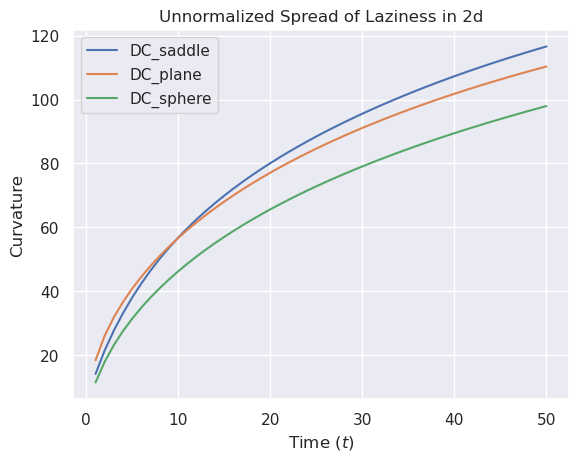

In [15]:
show_curvature_curves(DC_saddle, DC_plane, DC_sphere, 
                      num_ts=50, 
                      curvature_fn='unsigned_curvature',
                      title = "Unnormalized Spread of Laziness in 2d")

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

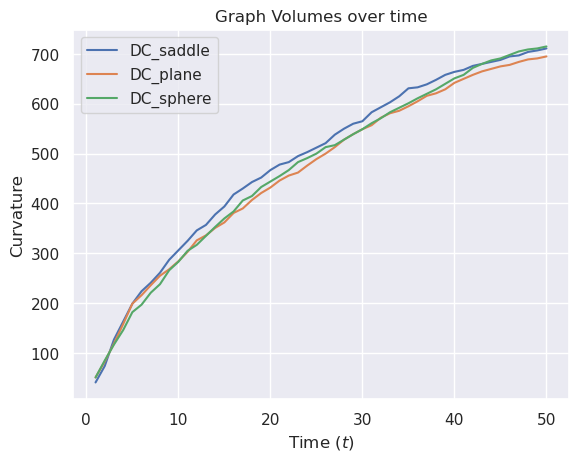

In [16]:
show_curvature_curves(DC_saddle, DC_plane, DC_sphere, 
                      num_ts=50, 
                      curvature_fn='division_normalized_laziness',
                      title = "Graph Volumes over time",
                      epsilon_threshold = 1/2000,
                      return_all = "volume"
                      )

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

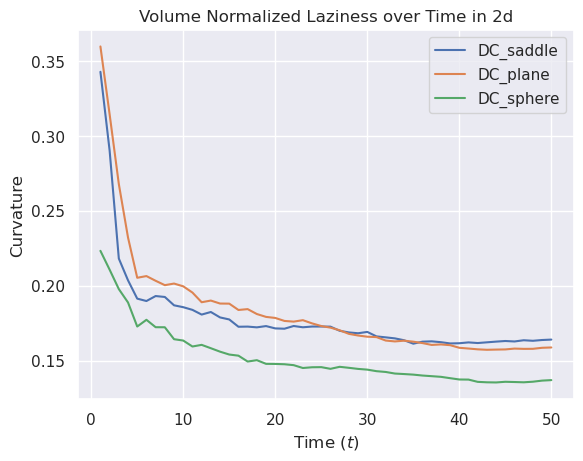

In [17]:
show_curvature_curves(DC_saddle, DC_plane, DC_sphere, 
                      num_ts=50, 
                      curvature_fn='division_normalized_laziness',
                      title = "Volume Normalized Laziness over Time in 2d",
                      epsilon_threshold = 1/2000,
                      )

Wasserstein to Uniform - unfortunately the EMD distances in exact form take far too long to practically compute.

In [81]:
show_curvature_curves(DC_saddle, DC_plane, DC_sphere, 
                      num_ts=5, 
                      curvature_fn='wasserstein_to_uniform',
                      title = "Wasserstein to Uniform Laziness over Time in 2d",
                      epsilon_threshold = 1/2000,
                      )

  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-29 10:17:55.217853: F external/xla/xla/stream_executor/cuda/cuda_driver.cc:163] Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error
2024-03-29 10:17:55.349644: F external/xla/xla/stream_executor/cuda/cuda_driver.cc:163] Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error


KeyboardInterrupt: 

Approximate Wasserstein to Uniform:

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

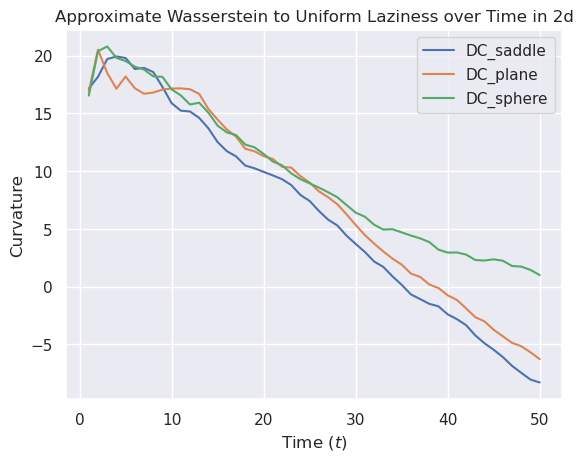

In [92]:
show_curvature_curves(DC_saddle, DC_plane, DC_sphere, 
                      num_ts=50, 
                      curvature_fn='wasserstein_to_uniform_approx',
                      title = "Approximate Wasserstein to Uniform Laziness over Time in 2d",
                      epsilon_threshold = 1/2000,
                      )

Wasserstein of Dirac to Uniform over diffused points above $\epsilon$ threshold:

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

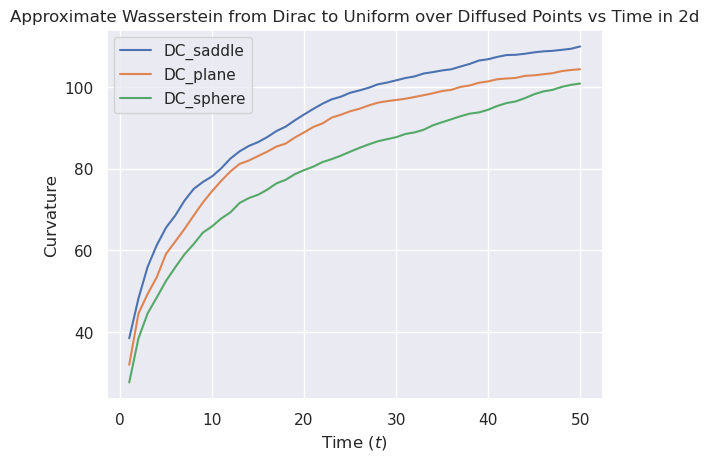

In [97]:
show_curvature_curves(DC_saddle, DC_plane, DC_sphere, 
                      num_ts=50, 
                      curvature_fn='wasserstein_dirac_to_uniform',
                      title = "Approximate Wasserstein from Dirac to Uniform over Diffused Points vs Time in 2d",
                      epsilon_threshold = 1/2000,
                      )

In [ ]:
DC_saddle.Pt.shape

(2000, 2000)

In [57]:
DC_saddle.D.shape

(2000, 2000)

## Visualization of 3d Curvature Curves with/without Graph Volume Normalization

Now here's a harder test: can the normalization distinguish regions which the unaided curvature curves cannot? With 3 manifolds, the curvature curves fail.



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

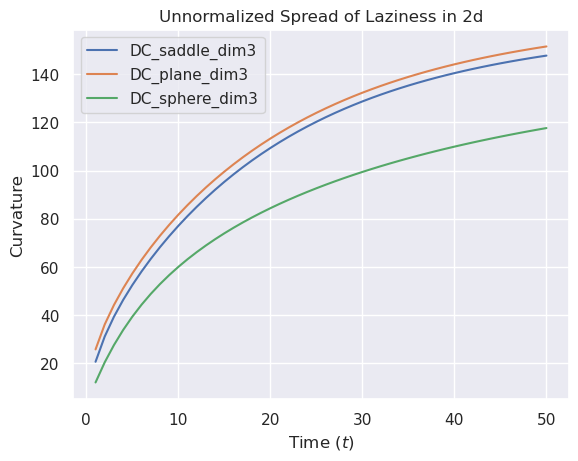

In [75]:
show_curvature_curves(DC_saddle_dim3, DC_plane_dim3, DC_sphere_dim3, 
                      num_ts=50, 
                      curvature_fn='unsigned_curvature',
                      title = "Unnormalized Spread of Laziness in 3d")

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

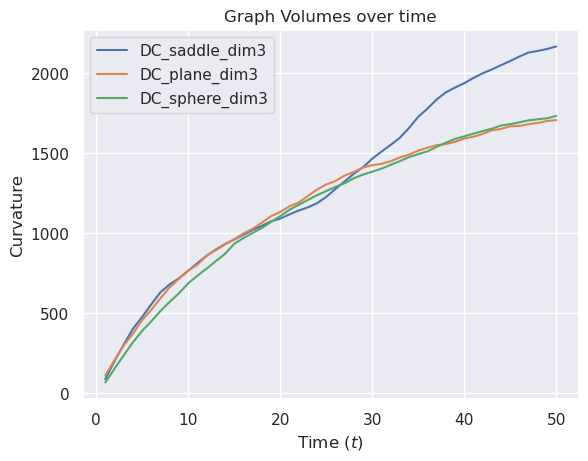

In [76]:
show_curvature_curves(DC_saddle_dim3, DC_plane_dim3, DC_sphere_dim3, 
                      num_ts=50, 
                      curvature_fn='division_normalized_laziness',
                      title = "Graph Volumes over time",
                      epsilon_threshold = 1/4000,
                      return_all = "volume"
                      )

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

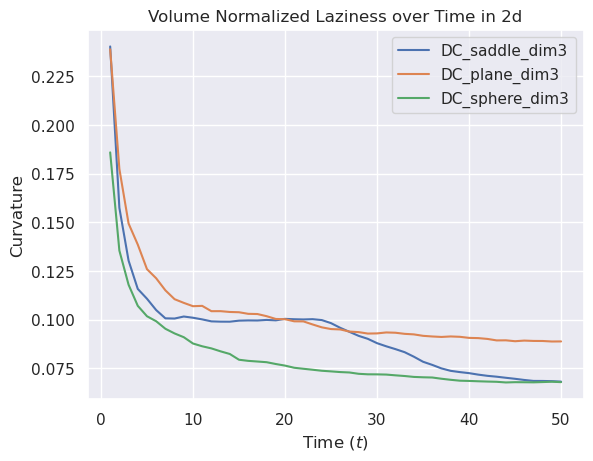

In [77]:
show_curvature_curves(DC_saddle_dim3, DC_plane_dim3, DC_sphere_dim3, 
                      num_ts=50, 
                      curvature_fn='division_normalized_laziness',
                      title = "Volume Normalized Laziness over Time in 3d",
                      epsilon_threshold = 1/4000,
                      )

## Visualization of 3d Curvature Curves differentiated wrt Graph Volume Normalization

Now here's a harder test: can the normalization distinguish regions which the unaided curvature curves cannot? With 3 manifolds, the curvature curves fail.



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

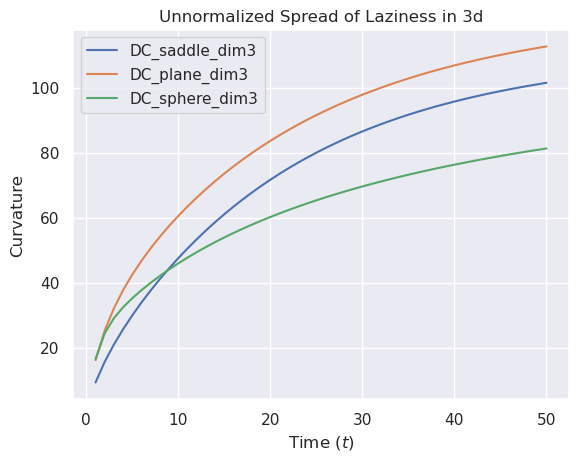

In [147]:
show_curvature_curves(DC_saddle_dim3, DC_plane_dim3, DC_sphere_dim3, 
                      num_ts=50, 
                      curvature_fn='unsigned_curvature',
                      title = "Unnormalized Spread of Laziness in 3d")

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

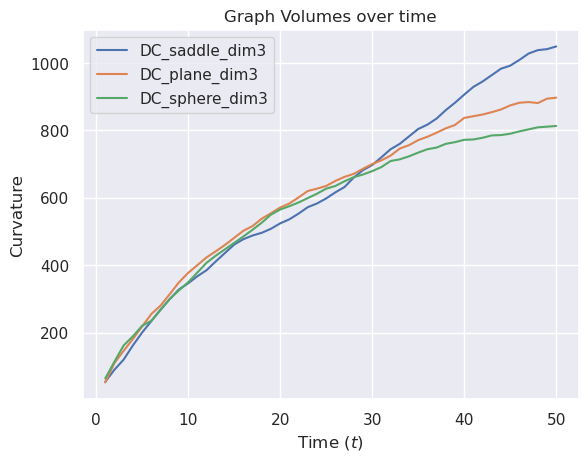

In [148]:
show_curvature_curves(DC_saddle_dim3, DC_plane_dim3, DC_sphere_dim3, 
                      num_ts=50, 
                      curvature_fn='division_normalized_laziness',
                      title = "Graph Volumes over time in 3d",
                      epsilon_threshold = 1/2000,
                      return_all = "volume"
                      )

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

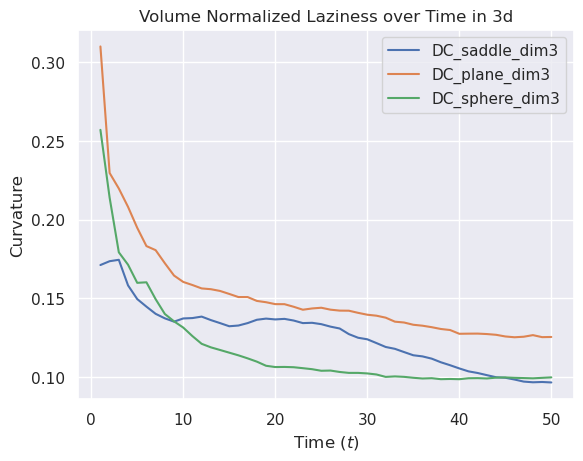

In [149]:
show_curvature_curves(DC_saddle_dim3, DC_plane_dim3, DC_sphere_dim3, 
                      num_ts=50, 
                      curvature_fn='division_normalized_laziness',
                      title = "Volume Normalized Laziness over Time in 3d",
                      epsilon_threshold = 1/2000,
                      )

In [112]:
show_curvature_curves(DC_saddle_dim3, DC_plane_dim3, DC_sphere_dim3, 
                      num_ts=50, 
                      curvature_fn='d_laziness_d_volume',
                      title = "Differentially Volume Normalized Laziness over Time in 3d",
                      epsilon_threshold = 1/2000,
                      )

  0%|          | 0/50 [00:00<?, ?it/s]

AttributeError: module 'jax.numpy' has no attribute 'concat'

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

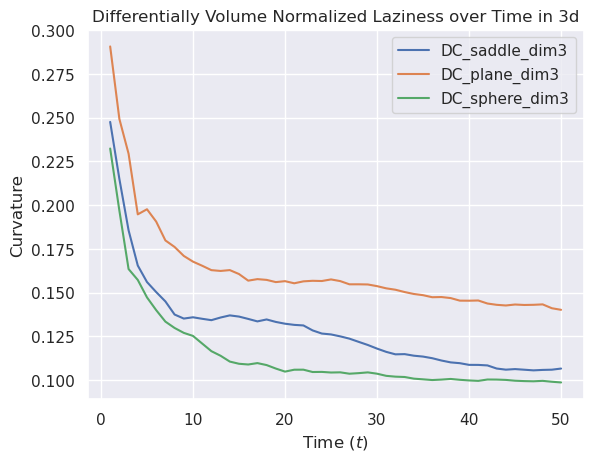

In [ ]:
show_curvature_curves(DC_saddle_dim3, DC_plane_dim3, DC_sphere_dim3, 
                      num_ts=50, 
                      curvature_fn='differential_volume_normalized_laziness',
                      title = "Differentially Volume Normalized Laziness over Time in 3d",
                      epsilon_threshold = 1/2000,
                      )

Approximation Wasserstein from Diffusion to Uniform

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

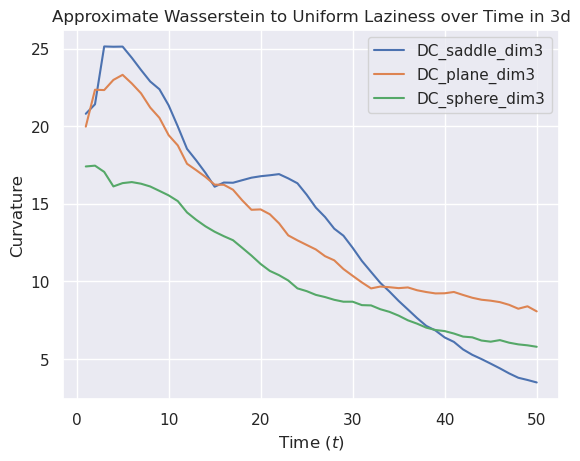

In [150]:
show_curvature_curves(DC_saddle_dim3, DC_plane_dim3, DC_sphere_dim3, 
                      num_ts=50, 
                      curvature_fn='wasserstein_to_uniform_approx',
                      title = "Approximate Wasserstein to Uniform Laziness over Time in 3d",
                      epsilon_threshold = 1/4000,
                      )

Wasserstein of Dirac to Uniform over diffused points above $\epsilon$ threshold:

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

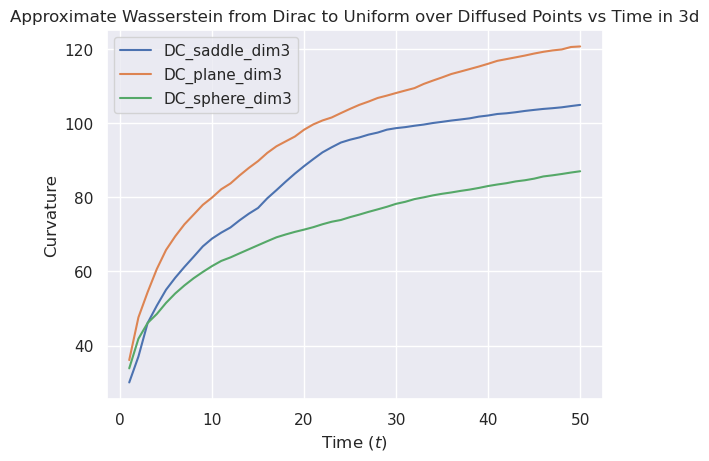

In [151]:
show_curvature_curves(DC_saddle_dim3, DC_plane_dim3, DC_sphere_dim3, 
                      num_ts=50, 
                      curvature_fn='wasserstein_dirac_to_uniform',
                      title = "Approximate Wasserstein from Dirac to Uniform over Diffused Points vs Time in 3d",
                      epsilon_threshold = 1/4000,
                      )

Wasserstein Spread divided by W1 of Dirac to Uniform

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

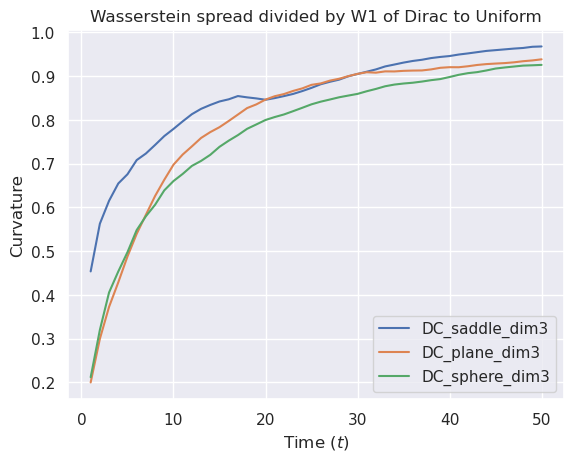

In [126]:
show_curvature_curves(DC_saddle_dim3, DC_plane_dim3, DC_sphere_dim3, 
                      num_ts=50, 
                      curvature_fn='divided_wasserstein_to_uniform_approx',
                      title = "Wasserstein spread divided by W1 of Dirac to Uniform",
                      epsilon_threshold = 1/4000,
                      )

## Visualization of 4d Curvatures

### Datasets

In [127]:
X_saddle, ks = rejection_sample_from_saddle(2000, intrinsic_dim=4)
graph_former = partial(get_adaptive_graph, alpha=1, k=1)
G_saddle = graph_former(X_saddle)
DC_saddle_dim4 = DiffusionCurvature(
    laziness_method="Wasserstein",
    graph_former=graph_former,
    distance_t = 25 # prevents the distances from changing along with the t value for easier comparison
)
ks = DC_saddle_dim4.fit_transform(G_saddle, dim=2, t=25)

2024-03-29 10:49:02,195:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-29 10:49:02,695:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


In [128]:
X_sphere, ks_sphere = sphere(2000, d=4)
graph_former = partial(get_adaptive_graph, alpha=1, k=1)
G_sphere = graph_former(X_sphere)
DC_sphere_dim4 = DiffusionCurvature(
    laziness_method="Wasserstein",
    graph_former = graph_former,
    distance_t = 25 # prevents the distances from changing along with the t value for easier comparison
)
ks = DC_sphere_dim4.fit_transform(G_sphere, dim=2, t=25)

2024-03-29 10:49:03,283:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-29 10:49:03,808:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


In [129]:
X_plane = plane(2000, dim=4)
graph_former = partial(get_adaptive_graph, alpha=1, k=1)
G_plane = graph_former(X_plane)
DC_plane_dim4 = DiffusionCurvature(
    laziness_method="Wasserstein",
    graph_former=graph_former,
    distance_t = 25 # prevents the distances from changing along with the t value for easier comparison
)
ks = DC_plane_dim4.fit_transform(G_plane, dim=2, t=25)

2024-03-29 10:49:04,313:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-29 10:49:04,792:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


### Methods

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

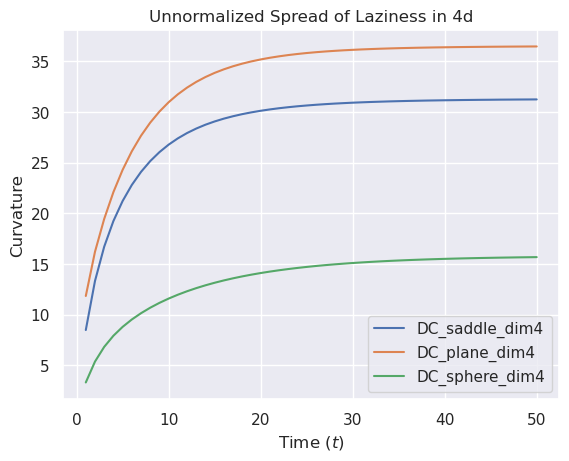

In [130]:
show_curvature_curves(DC_saddle_dim4, DC_plane_dim4, DC_sphere_dim4, 
                      num_ts=50, 
                      curvature_fn='unsigned_curvature',
                      title = "Unnormalized Spread of Laziness in 4d")

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

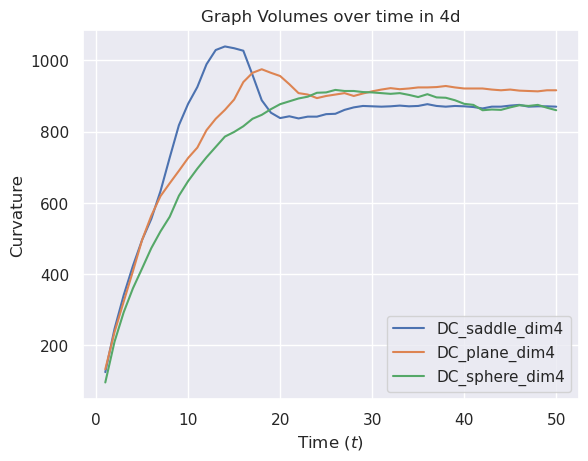

In [131]:
show_curvature_curves(DC_saddle_dim4, DC_plane_dim4, DC_sphere_dim4, 
                      num_ts=50, 
                      curvature_fn='division_normalized_laziness',
                      title = "Graph Volumes over time in 4d",
                      epsilon_threshold = 1/2000,
                      return_all = "volume"
                      )

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

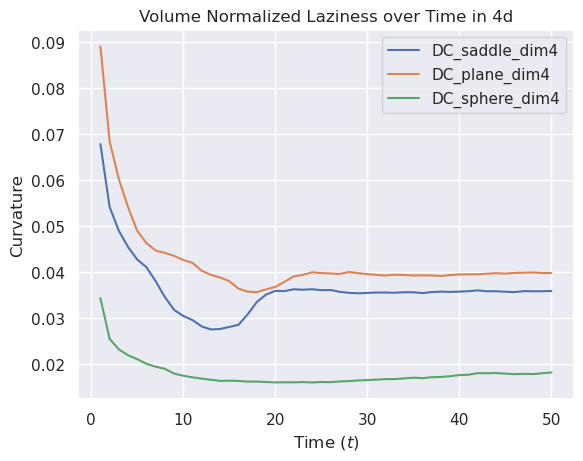

In [133]:
show_curvature_curves(DC_saddle_dim4, DC_plane_dim4, DC_sphere_dim4, 
                      num_ts=50, 
                      curvature_fn='division_normalized_laziness',
                      title = "Volume Normalized Laziness over Time in 4d",
                      epsilon_threshold = 1/2000,
                      )

Approximation Wasserstein from Diffusion to Uniform

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

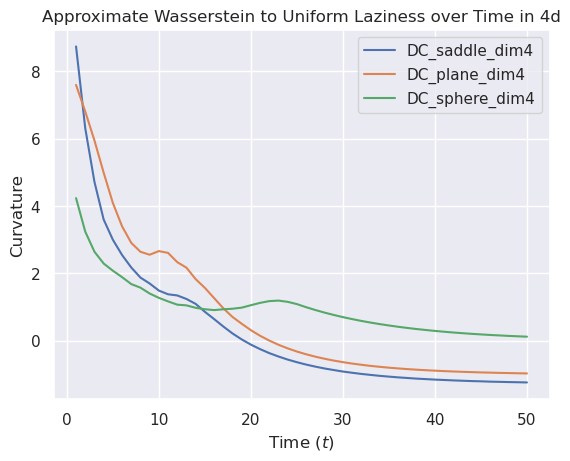

In [134]:
show_curvature_curves(DC_saddle_dim4, DC_plane_dim4, DC_sphere_dim4, 
                      num_ts=50, 
                      curvature_fn='wasserstein_to_uniform_approx',
                      title = "Approximate Wasserstein to Uniform Laziness over Time in 4d",
                      epsilon_threshold = 1/4000,
                      )

Wasserstein of Dirac to Uniform over diffused points above $\epsilon$ threshold:

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

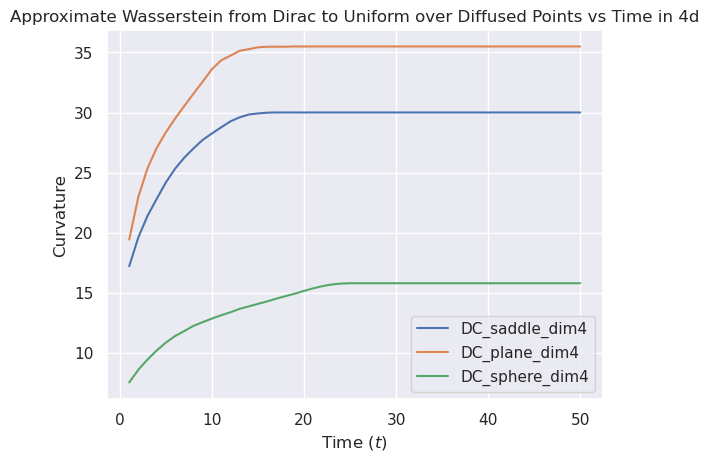

In [135]:
show_curvature_curves(DC_saddle_dim4, DC_plane_dim4, DC_sphere_dim4, 
                      num_ts=50, 
                      curvature_fn='wasserstein_dirac_to_uniform',
                      title = "Approximate Wasserstein from Dirac to Uniform over Diffused Points vs Time in 4d",
                      epsilon_threshold = 1/4000,
                      )

# Sadspheres Battery

In [136]:
import asyncio
from tqdm import trange
from diffusion_curvature.sadspheres import *

In [140]:
dim = 3
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 100, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes = True,
)

for i, X in tqdm(enumerate(SS)):
    for alpha in [1]:
        for k in [1,2,5,10]:
            graph_former = partial(get_adaptive_graph, alpha=alpha, k=k)
            G = graph_former(X)
            DC = DiffusionCurvature(
                laziness_method="Wasserstein",
                flattening_method="Fixed",
                comparison_method="Subtraction",
                graph_former=graph_former,
                points_per_cluster=None,  # construct separate comparison spaces around each point
                comparison_space_size_factor=1,
                distance_t=25,
            )
            ks = DC.division_normalized_laziness(G, t=12, return_all="volume", epsilon_threshold = 1/2000,)
            SS.update(ks[0], method_name=f"Volume with {k=} {alpha=}")

0it [00:00, ?it/s]

2024-03-29 11:08:07,098:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-29 11:08:07,590:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-29 11:08:08,093:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-29 11:08:08,627:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-29 11:08:09,095:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-29 11:08:09,513:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-29 11:08:10,051:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-29 11:08:10,534:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-29 11:08:10,980:[WARNING](pygsp.graphs.graph.che

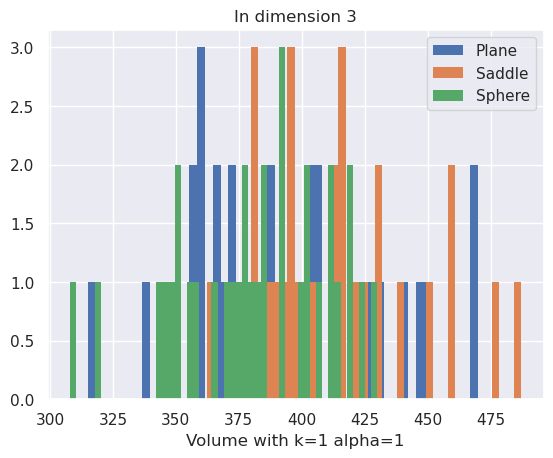

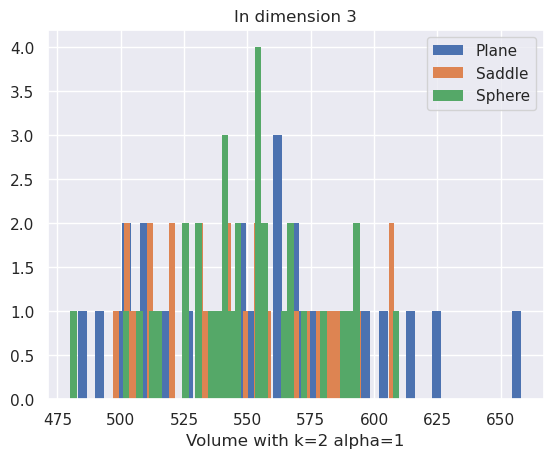

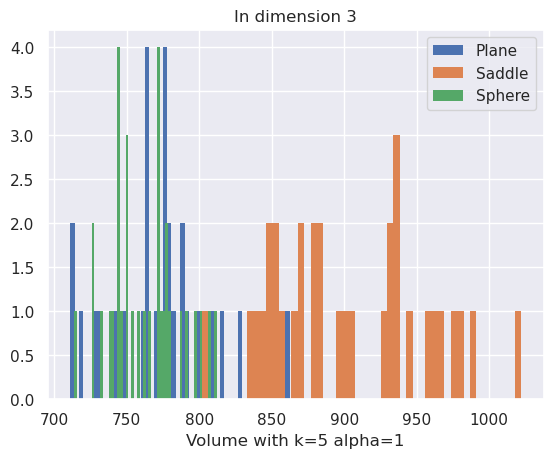

,pearson_r,sign_score
ks,"(1.0, 0.0)",1.098612
Volume with k=1 alpha=1,"(-0.2884665039688182, 0.0037846556045183976)",0.000000
Volume with k=2 alpha=1,"(-0.0015295563703801363, 0.9880117433301466)",0.000000
Volume with k=5 alpha=1,"(-0.8412814231562036, 1.1734781277987382e-27)",0.000000


In [139]:
SS.plot()
SS.table()

# Conclusion